In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
_optimizer = Adam(0.0002, 0.5)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def load_imgs(path, number, train_type):
    result=np.empty((number, 256, 256, 3), dtype="uint8")
    for i in range(number):
        I = cv2.imread(path + "{:05}_{}.jpeg".format(i+1, train_type))
        I = cv2.resize(I, (0,0), fx=0.5, fy=0.5)
        result[i, :, :, :] = I
    return result

In [3]:
# '''load images, parse test/validation set'''

dataNum = 1000
dataPath = "/home/qian/Downloads/highres_dataset/"
x1 = load_imgs(dataPath, dataNum, 1)
x2 = load_imgs(dataPath, dataNum, 2)
y = load_imgs(dataPath, dataNum, 0)
#y = y[:, 8:-8, 8:-8, :]
mask = load_imgs(dataPath, dataNum, 4)
mask = 255-mask[:, :, :, :1]

x_train1, x_test1, x_train2, x_test2, y_train, y_test, mask_train, mask_test = train_test_split(
    x1, x2, y, mask, test_size=0.20)

In [4]:
# plt.imshow(y[0, :, :, :])
# plt.show()
# print(y.max())
# print(mask.shape)

In [5]:
def encoder_block(x, _filters, _kernel_size, _strides, bn = True):
    y = layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(x)
    if bn is True:
        y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    y = layers.ReLU()(y)
    return y

In [6]:
def encoder_net(y):
    y = encoder_block(y, 32, (5, 5), (4, 4), bn = False)
    y = encoder_block(y, 128, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
    y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#   y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#    y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#     y = layers.Flatten()(y)
#     y = layers.Dense(256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)
    return y

In [7]:
def decoder_block(x, _filters, _kernel_size, _strides, dropout = False):
    y = layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size, 
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    if dropout is True:
        y = layers.Dropout(0.5)(y)
    y = layers.ReLU()(y)
    return y

In [8]:
def decoder_net(y):
#     y = layers.Dense(8*8*256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)

#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)
#     y = layers.Reshape((8, 8, 256))(y)
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2), False)
    y = decoder_block(y, 256, (5, 5), (4, 4), False)
    y = decoder_block(y, 128, (5, 5), (4, 4), False)
    #print(y._keras_shape)
    y = decoder_block(y, 32, (5, 5), (4, 4), False)
    y = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    #y = layers.Softmax(axis = -1)(y)
    return y

In [9]:
def fusionnet(inTensor1, inTensor2):
    out1 = encoder_net(inTensor1)
    out2 = encoder_net(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(x)
    return y

In [10]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
#     # crop the input images to the same size as network output.
#     inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
#     inCrop2 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor2)
    y = K.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
    return y

In [11]:
img1 = layers.Input(shape=(256, 256, 3))
img2 = layers.Input(shape=(256, 256, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [12]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   2432        input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_1 (R

In [13]:
'''train on generator using MSE of pred & mask.'''
generator.compile(loss=[losses.mean_squared_error,'mse'], loss_weights=[1,0], optimizer= _optimizer)
generator.fit([x_train1/127.5-1, x_train2/127.5-1], [y_train/127.5-1, mask_train/127.5-1], batch_size = 16, epochs = 50)
# batchSize = 16
# losses = []
# for e in range(1000):
#     rand_idx = np.random.randint(0, x_train1.shape[0], size = batchSize)
#     img_batch1 = x_train1[rand_idx, :, :, :].astype('float16')/127.5-1
#     img_batch2 = x_train2[rand_idx, :, :, :].astype('float16')/127.5-1
#     mask_batch = mask_train[rand_idx, :, :, :].astype('float16')/127.5-1
#     y_batch = y_train[rand_idx, :, :, :].astype('float16')/127.5-1
#     loss = generator.train_on_batch([img_batch1, img_batch2], [y_batch, mask_batch])
#     print(loss[0])

Epoch 1/10
800/800 [==============================] - 21s 26ms/step - loss: 0.0082 - lambda_1_loss: 0.0082 - conv2d_9_loss: 0.5927
Epoch 2/10
800/800 [==============================] - 14s 18ms/step - loss: 0.0074 - lambda_1_loss: 0.0074 - conv2d_9_loss: 0.5869
Epoch 3/10
800/800 [==============================] - 14s 18ms/step - loss: 0.0067 - lambda_1_loss: 0.0067 - conv2d_9_loss: 0.5732
Epoch 4/10
800/800 [==============================] - 14s 18ms/step - loss: 0.0063 - lambda_1_loss: 0.0063 - conv2d_9_loss: 0.5695
Epoch 5/10
800/800 [==============================] - 14s 18ms/step - loss: 0.0058 - lambda_1_loss: 0.0058 - conv2d_9_loss: 0.5375
Epoch 6/10
800/800 [==============================] - 14s 18ms/step - loss: 0.0055 - lambda_1_loss: 0.0055 - conv2d_9_loss: 0.5193
Epoch 7/10
800/800 [==============================] - 14s 18ms/step - loss: 0.0050 - lambda_1_loss: 0.0050 - conv2d_9_loss: 0.4628
Epoch 8/10
800/800 [==============================] - 15s 18ms/step - loss: 0.0048 

In [24]:
prediction, a= generator.predict([x_train1[:10, :, :, :]/127.5-1, x_train2[:10, :, :, :]/127.5-1])
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].output])

layer_output = np.array(get_layer_output([x_train1[:10, :, :, :]/127.5-1, x_train2[:10, :, :, :]/127.5-1])[0])
#print(prediction.max())

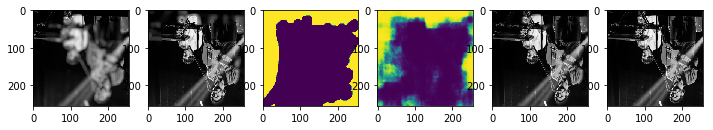

In [29]:
imgIdx = 4
fig=plt.figure(figsize=(12, 12))
columns = 6
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(x_train1[imgIdx, :, :, :])
fig.add_subplot(rows, columns, 2)
plt.imshow(x_train2[imgIdx, :, :, :])
fig.add_subplot(rows, columns, 3)
plt.imshow(mask_train[imgIdx, :, :, 0])
fig.add_subplot(rows, columns, 4)
plt.imshow((layer_output[imgIdx, :, :, 0]+1)/2)
fig.add_subplot(rows, columns, 5)
plt.imshow((prediction[imgIdx, :, :, :]+1)/2)
fig.add_subplot(rows, columns, 6)
plt.imshow(y_train[imgIdx, :, :, :])
plt.show()
# fig.savefig(dataPath+"results/struc_loss{:.2E}.png".format(lambda_tv))